In [7]:
import numpy as np
def fetch(url):
    import requests, gzip, os, hashlib, numpy as np
    fp = os.path.join('tmp/' + hashlib.md5(url.encode('utf-8')).hexdigest() + '.gz')
    if os.path.isfile(fp):
        with open(fp, 'rb') as f:
            dat = f.read()
    else:
        with open(fp, 'wb') as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [8]:
import torch.nn as nn
import torch
class BobNet(nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x

model = BobNet()

In [9]:
from PIL import Image

img = Image.open('./tmp/eight.png')

numpydata = np.asarray(img)



In [10]:
from tqdm import trange

In [11]:
batch = 128
optim = torch.optim.Adam(model.parameters())
for i in ( t := trange(10000)):
    samp = torch.randint(0, X_train.shape[0], (batch,))

    out = model(torch.tensor(X_train[samp]).flatten(1).float())

    loss = nn.functional.cross_entropy(out, torch.tensor(Y_train[samp]))

    optim.zero_grad()

    loss.backward()

    optim.step()

    t.set_description(f'loss {loss.item():.2f}')

loss 0.07: 100%|██████████| 10000/10000 [00:15<00:00, 626.61it/s]


In [12]:
Y_pred = torch.argmax(model(torch.tensor(X_test).flatten(1).float()), dim=1).numpy()

accuracy = (Y_pred == Y_test).mean()
accuracy

0.9664

In [13]:
import torch
import torch.nn.functional as F

8


/var/folders/7m/w8k84tcn19d4k10r234_g4lr0000gn/T/ipykernel_82228/2227876900.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred =  torch.argmax(F.softmax(model(torch.tensor(X_train[ix]).flatten(1).float()))).item()


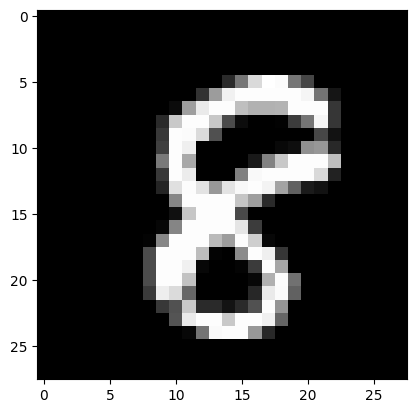

In [122]:
import matplotlib.pyplot as plt

ix = np.random.randint(0, X_train.shape[0], [1,])

pred =  torch.argmax(F.softmax(model(torch.tensor(X_train[ix]).flatten(1).float()))).item()

print(pred)

plt.imshow(X_train[ix].squeeze(), cmap='gray')
plt.show()

In [16]:
l1 = model.l1.weight.detach().numpy().transpose()
l2 = model.l2.weight.detach().numpy().transpose()

In [17]:
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x

In [94]:
Y_test_preds_out = forward(X_test.reshape(-1, 28*28))

Y_test_preds = np.argmax(Y_test_preds_out, axis=1)

In [156]:
ret = -Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] 
ret

array([-57.776417, -26.787006, -39.763832, ..., -51.96136 , -52.744717,
       -69.44498 ], dtype=float32)

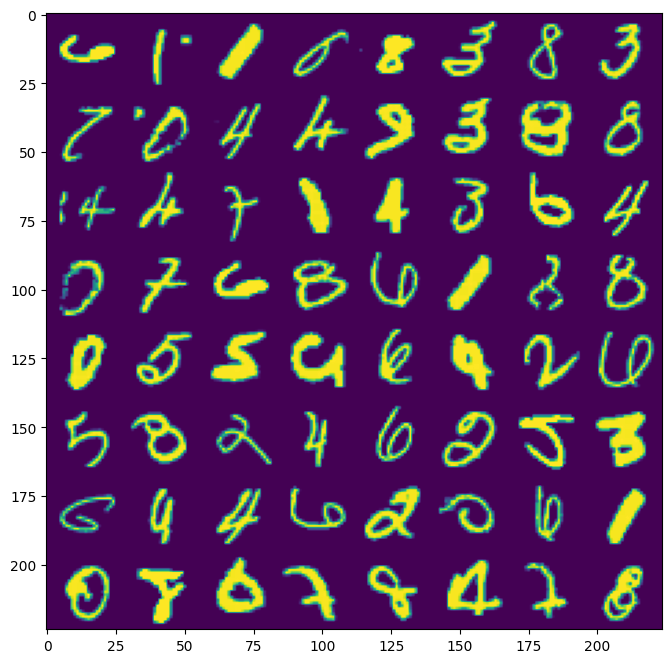

In [204]:
g = 8

grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse=True)[:g**2]

X_bad = X_test[[x[1] for x in grid]]

plt.figure(figsize=(8, 8))
plt.imshow(np.concatenate(X_bad.reshape(g, 28*g, 28), axis=1))